In [1]:
import numpy as np
import pylab as plt
import pandas as pd
import scipy.misc
import random
import pickle
import glob
import os

from pprint import pprint
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
path2dataset = "/mnt/Behavioral-Cloning-Dataset/"
path2images = path2dataset + "IMG/"
pattern = "*.jpg"
path2csv = path2dataset + "driving_log_master.csv"
path2csv_cleaned = path2dataset + "driving_log_cleaned.csv"
path2csv_training = path2dataset + "driving_log_training.csv"
path2csv_validation = path2dataset + "driving_log_validation.csv"
path2prob_tools = path2dataset + "prob_tools.pkl"

csv_column_names = ["Center Image", "Left Image", "Right Image", "Steering Angle", "Throttle", "Break", "Speed"]

# CSV Merging 
### (this part is optional and not always will be needed)

In [3]:
# My dataset comes from various sources, so I need to combine the CSV into just one file.
# IMGs directorys are already merged with a bash command like this: 
# mv ~/SDC/Behavioral-Cloning-Dataset/race1/IMG/* ~/SDC/Behavioral-Cloning-Dataset/IMG/

all_csv = glob.glob(path2dataset + "*.csv")

df_master = pd.DataFrame()
df_ls = list()
df_lengths = list()

for file in all_csv:
    df = pd.read_csv(file, index_col=None, header=None)
    df_ls.append(df)
    df_lengths.append(len(df))
    
df_master = pd.concat(df_ls)
df_master.columns = csv_column_names

print("CSV statistics:")
print("File lengths: ", df_lengths)
print("Total records: ", sum(df_lengths))
print("Master file length: ", len(df_master))

CSV statistics:
File lengths:  [8961, 2747, 1795, 32708, 5994]
Total records:  52205
Master file length:  52205


In [4]:
df_master.head()

,Center Image,Left Image,Right Image,Steering Angle,Throttle,Break,Speed
0,C:\Users\Antonio\Desktop\coche\IMG\center_2017...,NaN,NaN,0.0,0.0,0,18.89537
1,C:\Users\Antonio\Desktop\coche\IMG\center_2017...,NaN,NaN,0.0,0.0,0,18.78023
2,C:\Users\Antonio\Desktop\coche\IMG\center_2017...,NaN,NaN,0.0,0.0,0,18.62780
3,C:\Users\Antonio\Desktop\coche\IMG\center_2017...,NaN,NaN,0.0,0.0,0,18.51448
4,C:\Users\Antonio\Desktop\coche\IMG\center_2017...,NaN,NaN,0.0,0.0,0,18.36437


In [5]:
# Let's save this dataframe into a CSV so this part of code is independent of the next one
df_master.to_csv(path2csv, index=False)

# CSV Preprocessing

In [3]:
df = pd.read_csv(path2csv)
df.head()

,Center Image,Left Image,Right Image,Steering Angle,Throttle,Break,Speed
0,E:\Datos\Nanodegree self-driving car (coches a...,NaN,NaN,0.0,0.0,0,0.000020
1,E:\Datos\Nanodegree self-driving car (coches a...,NaN,NaN,0.0,0.0,0,0.000001
2,E:\Datos\Nanodegree self-driving car (coches a...,NaN,NaN,0.0,0.0,0,0.000004
3,E:\Datos\Nanodegree self-driving car (coches a...,NaN,NaN,0.0,0.0,0,0.000009
4,E:\Datos\Nanodegree self-driving car (coches a...,NaN,NaN,0.0,0.0,0,0.000022


In [4]:
df.dtypes

Center Image       object
Left Image         object
Right Image        object
Steering Angle    float64
Throttle          float64
Break               int64
Speed             float64
dtype: object

In [5]:
df.describe()

,Steering Angle,Throttle,Break,Speed
count,52205.000000,52205.000000,52205.0,5.220500e+04
mean,-0.036005,0.966006,0.0,2.943086e+01
std,0.120632,0.177005,0.0,4.091717e+00
min,-1.000000,0.000000,0.0,3.583549e-07
25%,-0.066667,1.000000,0.0,3.018968e+01
50%,0.000000,1.000000,0.0,3.019014e+01
75%,0.000000,1.000000,0.0,3.019029e+01
max,1.000000,1.000000,0.0,3.061606e+01


In [6]:
df.drop(["Left Image", "Right Image", "Break"], axis=1, inplace=True)

In [7]:
df.head()

,Center Image,Steering Angle,Throttle,Speed
0,E:\Datos\Nanodegree self-driving car (coches a...,0.0,0.0,0.000020
1,E:\Datos\Nanodegree self-driving car (coches a...,0.0,0.0,0.000001
2,E:\Datos\Nanodegree self-driving car (coches a...,0.0,0.0,0.000004
3,E:\Datos\Nanodegree self-driving car (coches a...,0.0,0.0,0.000009
4,E:\Datos\Nanodegree self-driving car (coches a...,0.0,0.0,0.000022


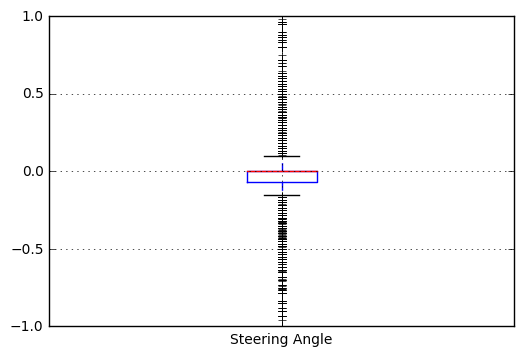

In [8]:
df[["Steering Angle"]].boxplot()

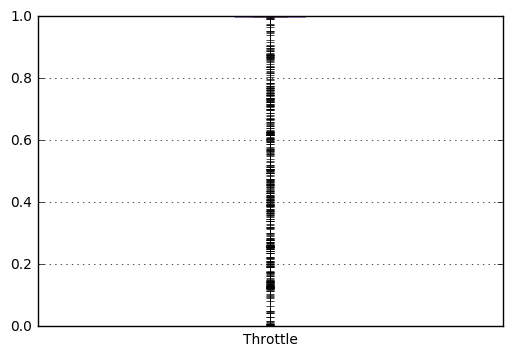

In [9]:
df[["Throttle"]].boxplot()

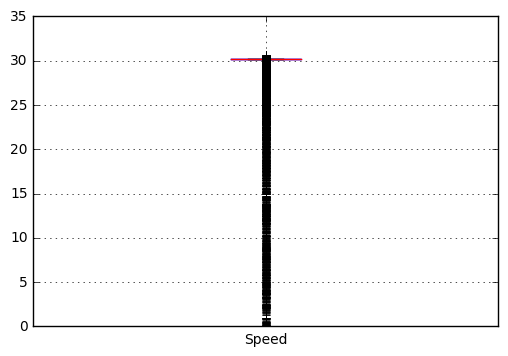

In [10]:
df[["Speed"]].boxplot()

In [8]:
df2 = df[["Center Image", "Steering Angle"]].copy()
df2.columns = ["Original image path", "Steering angle"]

In [9]:
string = df2.ix[0, "Original image path"]
string

'E:\\Datos\\Nanodegree self-driving car (coches autonomos)\\dataset_behavioral_cloning\\IMG\\center_2017_01_22_23_33_27_848.jpg'

In [10]:
os.path.basename(string)

'E:\\Datos\\Nanodegree self-driving car (coches autonomos)\\dataset_behavioral_cloning\\IMG\\center_2017_01_22_23_33_27_848.jpg'

It doesn't work because it is calling the Linux separator "/" but the simulator was run in Windows and the paths have the separator "\" 

In [11]:
string.split("\\")

['E:',
 'Datos',
 'Nanodegree self-driving car (coches autonomos)',
 'dataset_behavioral_cloning',
 'IMG',
 'center_2017_01_22_23_33_27_848.jpg']

In [12]:
updated_directory = path2images

def update_path(path):
    return updated_directory + path.split("\\")[-1]


df2["Updated image path"] = df2["Original image path"].apply(update_path)

In [13]:
df2.head()

,Original image path,Steering angle,Updated image path
0,E:\Datos\Nanodegree self-driving car (coches a...,0.0,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...
1,E:\Datos\Nanodegree self-driving car (coches a...,0.0,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...
2,E:\Datos\Nanodegree self-driving car (coches a...,0.0,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...
3,E:\Datos\Nanodegree self-driving car (coches a...,0.0,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...
4,E:\Datos\Nanodegree self-driving car (coches a...,0.0,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...


In [14]:
df2.ix[0, "Updated image path"]

'/mnt/Behavioral-Cloning-Dataset/IMG/center_2017_01_22_23_33_27_848.jpg'

There are some images that were deleted because I ended up in the river or crashed against a tree, hence, need to be removed from the csv

In [15]:
rows_before = len(df2)
print("Rows before: %d" % rows_before)

Rows before: 52205


In [16]:
df2["Exists"] = df2["Updated image path"].apply(lambda x: os.path.exists(x))

In [17]:
df2.columns

Index(['Original image path', 'Steering angle', 'Updated image path',
       'Exists'],
      dtype='object')

In [18]:
df3 = df2[df2["Exists"] == True]
df3 = df3[["Updated image path", "Steering angle"]].reset_index(drop=True).copy()
df3.head()

,Updated image path,Steering angle
0,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,0.0
1,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,0.0
2,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,0.0
3,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,0.0
4,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,0.0


In [19]:
rows_after = len(df3)
difference = rows_before - rows_after
percentage = difference/rows_before*100
print("There were %d rows deleted of %d (%.2f%% deleted)" % (difference, rows_before, percentage))

There were 2522 rows deleted of 52205 (4.83% deleted)


In [20]:
df3.to_csv(path2csv_cleaned, index=False)

# Image analysis

In [24]:
test_im = scipy.misc.imread(df3.ix[0, "Updated image path"])

In [25]:
test_im.shape

(160, 320, 3)

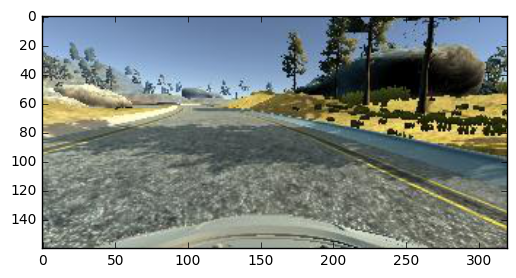

In [26]:
_ = plt.imshow(test_im)

Do we really need what is over the horizont? I mean, over 50pix seems there is no any relevant information. The same could apply to the pixeles below 140. Let's visualize some images.

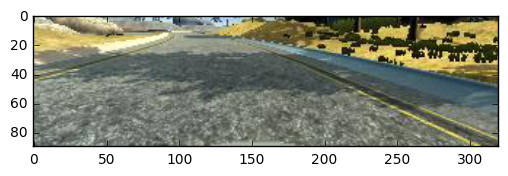

In [27]:
_ = plt.imshow(test_im[50:140, :])

Mmm... I suspect that visualizing the center of the car in the image will provide useful information such as "the piece I can see from the car should be in the center of the lane lines". Let's keep it.

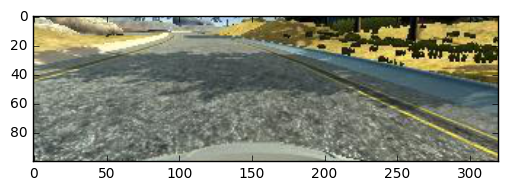

In [28]:
_ = plt.imshow(test_im[50:150, :])

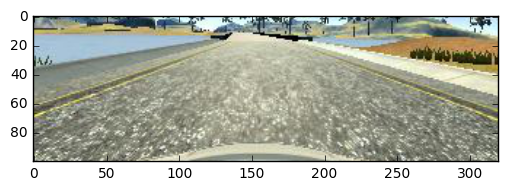

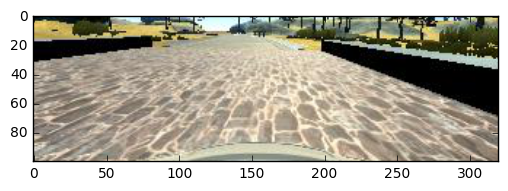

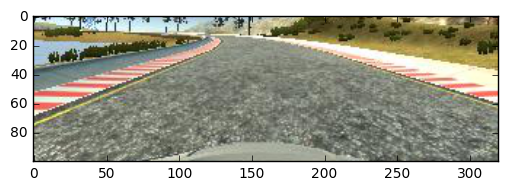

In [29]:
# Let's visualize 3 random images

np.random.seed(1234)
random1 = scipy.misc.imread(df3.ix[random.randint(0, len(df3)), "Updated image path"])
random2 = scipy.misc.imread(df3.ix[random.randint(0, len(df3)), "Updated image path"])
random3 = scipy.misc.imread(df3.ix[random.randint(0, len(df3)), "Updated image path"])

plt.figure()
_ = plt.imshow(random1[50:150, :])
plt.figure()
_ = plt.imshow(random2[50:150, :])
plt.figure()
_ = plt.imshow(random3[50:150, :])

Maybe we can be more restrictive cropping a bit more in the top, but as it is right now should be fine.

Every time we load an image we will have to apply a crop like img[50:150, :]

# Experimental setup: train/val splits

### Visualize angle distribution

In [30]:
df3.head()

,Updated image path,Steering angle
0,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,-0.5
1,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,0.0
2,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,0.0
3,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,0.0
4,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,0.0


[   57    24    30    73    92   285   720  1894  7299 11549 26909  1083
   488   320    63   101    32     9    41    47]
[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9  1. ]


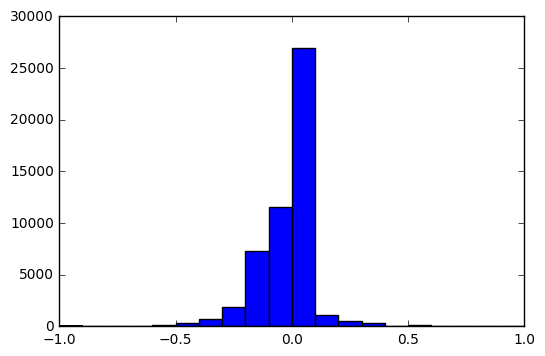

In [31]:
ret = plt.hist(df3['Steering angle'], 20)

count = ret[0].astype(np.int)
bins = ret[1]

print(count)
print(bins)

In [32]:
df3['Bin'] = np.digitize(df3['Steering angle'], bins)

In [33]:
Prob_bin_appearance = count/np.sum(count)

[ 0.001  0.     0.001  0.001  0.002  0.006  0.014  0.037  0.143  0.226
  0.526  0.021  0.01   0.006  0.001  0.002  0.001  0.     0.001  0.001]


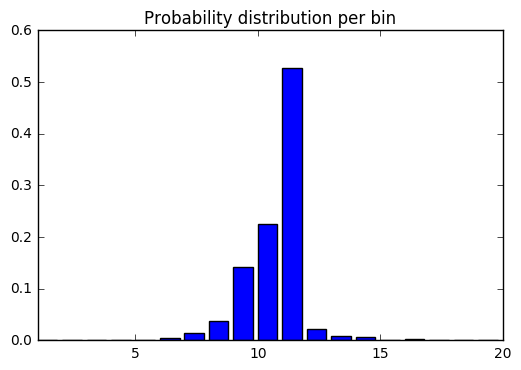

In [34]:
print(np.around(Prob_bin_appearance, 3))
_ = plt.bar(range(1, len(Prob_bin_appearance)+1), Prob_bin_appearance)
_ = plt.title("Probability distribution per bin")
_ = plt.xlim([1, 20])

In [35]:
# converter maps bin id -> probability
converter = dict(zip(range(1,len(bins)), Prob_bin_appearance))
df3['Probability appearance'] = df3['Bin'].apply(lambda x: converter[x])

KeyError: 21

In [36]:
df3[df3['Bin'] == 21].head()

,Updated image path,Steering angle,Bin
7415,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,1.0,21
7416,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,1.0,21
12641,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,1.0,21
12642,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,1.0,21
12643,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,1.0,21


The problem is the threshold operation: the right edge is not included in the bin. But there is an easy solution

In [37]:
df3.loc[df3['Bin'] == 21, 'Bin'] = 20

In [38]:
len(df3[df3['Bin'] == 20])

47

In [39]:
# Everything seems correct. Let's try it again
df3['Probability appearance'] = df3['Bin'].apply(lambda x: converter[x])

In [40]:
df3.head()

,Updated image path,Steering angle,Bin,Probability appearance
0,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,-0.5,6,0.005576
1,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,0.0,11,0.526430
2,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,0.0,11,0.526430
3,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,0.0,11,0.526430
4,/mnt/Behavioral-Cloning-Dataset/IMG/center_201...,0.0,11,0.526430


### Save dataset

In [43]:
# Training set will be 80% data and Validation set will be 20%

X = df3['Updated image path'].values
Y = df3['Steering angle'].values
Labels = df3['Bin'].values

X_train, X_validation, Y_train, Y_validation = \
train_test_split(X, Y,test_size=0.2, random_state=42 ,stratify=Labels)

# Training CSV
pd.DataFrame({'Updated image path': X_train, 'Steering angle': Y_train}).to_csv(path2csv_training, index=False)
# Validation CSV
pd.DataFrame({'Updated image path': X_validation, 'Steering angle': Y_validation}).to_csv(path2csv_validation, index=False)

In [47]:
# Probability appearance is needed in training for data augmentation purposes in order to reduce the bias in this set.
prob_tools = {'bins': bins, 'converter': converter}

pickle.dump(prob_tools, open(path2prob_tools, 'wb'))